In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
import numpy as np

from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from ngboost import NGBClassifier
from ngboost.ngboost import NGBoost
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal, LogNormal
from ngboost.distns import k_categorical
from sklearn.metrics import classification_report
plt.style.use('ggplot')

In [2]:
from rdkit.Chem import RDConfig

In [3]:
train = os.path.join(RDConfig.RDDocsDir, 'Book/data/solubility.train.sdf')
train_mols = [m for m in Chem.SDMolSupplier(train)]
test = os.path.join(RDConfig.RDDocsDir, 'Book/data/solubility.test.sdf')
test_mols = [m for m in Chem.SDMolSupplier(test)]

In [4]:
print(train_mols[0].GetPropsAsDict())

{'ID': 1, 'NAME': 'n-pentane', 'SOL': -3.18, 'SOL_classification': '(A) low', 'smiles': 'CCCCC'}


In [5]:
cls = set([m.GetProp('SOL_classification') for m in train_mols])

In [6]:
print(cls)

{'(C) high', '(A) low', '(B) medium'}


In [7]:
clsdict = {c:i for i, c in enumerate(cls)}

In [8]:
def mol2arr(mol, radi=2, nBits=1024):
    arr = np.zeros((0,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radi, nBits)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [9]:
trainX = np.array([mol2arr(m) for m in train_mols])
trainY = np.array([clsdict[m.GetProp('SOL_classification')] for m in train_mols])
trainY2 = np.array([np.float(m.GetProp('SOL')) for m in train_mols])

testX = np.array([mol2arr(m) for m in test_mols])
testY = np.array([clsdict[m.GetProp('SOL_classification')] for m in test_mols])
testY2 = np.array([np.float(m.GetProp('SOL')) for m in test_mols])

In [10]:
adbcls = AdaBoostClassifier()
svc = SVC(probability=True)
ngbc = NGBClassifier(Dist=k_categorical(3))
clsset = [adbcls, svc, ngbc]

In [11]:
for clsfier in clsset:
    clsfier.fit(trainX, trainY)

[iter 0] loss=1.0555 val_loss=0.0000 scale=2.0000 norm=6.8284
[iter 100] loss=0.8212 val_loss=0.0000 scale=1.0000 norm=2.7407
[iter 200] loss=0.7623 val_loss=0.0000 scale=1.0000 norm=2.6329
[iter 300] loss=0.7306 val_loss=0.0000 scale=1.0000 norm=2.5840
[iter 400] loss=0.7077 val_loss=0.0000 scale=1.0000 norm=2.5443


In [12]:
testres = []
for clsfier in clsset:
    res = clsfier.predict(testX)
    testres.append(res)

100%|██████████| 20/20 [00:00<00:00, 62.50it/s]


<Figure size 432x288 with 0 Axes>

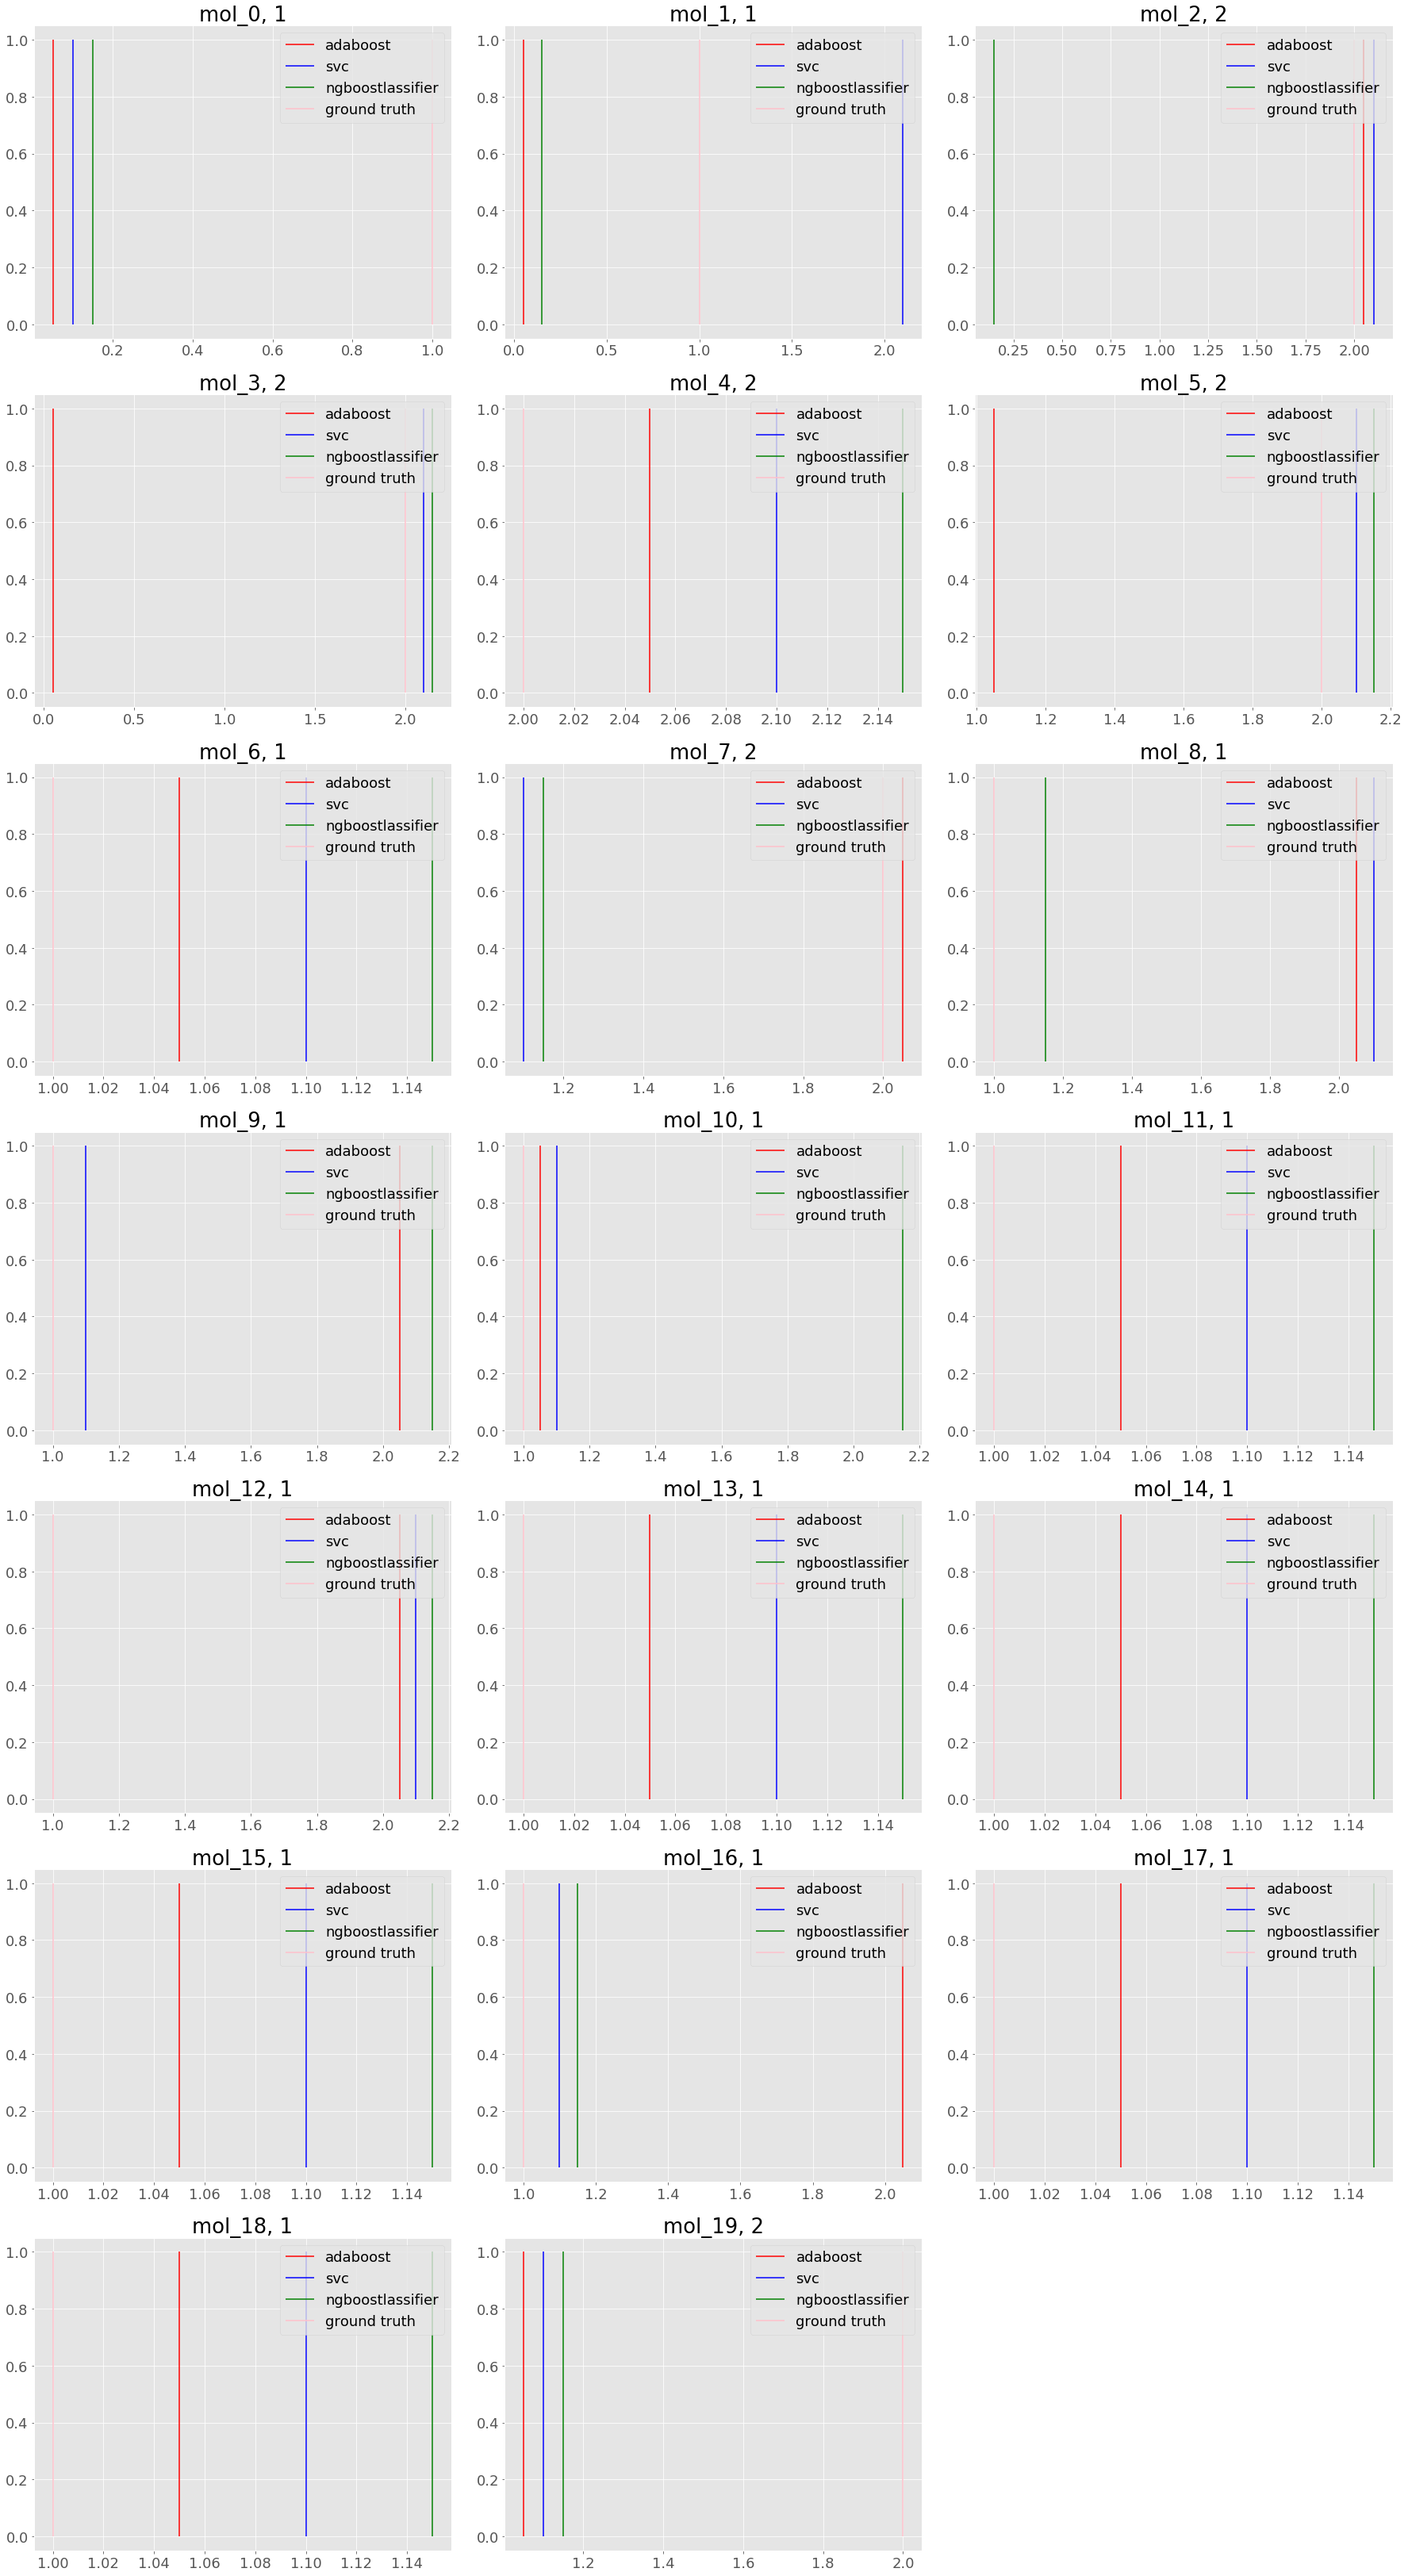

In [13]:
N=20
plt.clf()
plt.rcParams["font.size"] = 18
from tqdm import tqdm
plt.figure(figsize=(25, 129))
for idx in tqdm(np.arange(testX[:N].shape[0])):
    plt.subplot(N, 3, idx+1)
    plt.vlines(testres[0][idx]+0.05, 0, 1, 'r', label='adaboost')
    plt.vlines(testres[1][idx]+0.1, 0, 1, 'b', label='svc')
    plt.vlines(testres[2][idx]+0.15, 0, 1, 'g', label='ngboostlassifier')
    plt.vlines(testY[idx], 0, 1, "pink", label="ground truth")
    plt.legend(loc="best")
    plt.title(f'mol_{idx}, {testY[idx]}')
plt.tight_layout()
plt.show()

In [14]:
#AdaBoost
print(classification_report(testY, testres[0]))

              precision    recall  f1-score   support

           0       0.55      0.60      0.57        40
           1       0.69      0.58      0.63       102
           2       0.60      0.67      0.63       115

    accuracy                           0.62       257
   macro avg       0.61      0.62      0.61       257
weighted avg       0.63      0.62      0.62       257



In [15]:
#SVC
print(classification_report(testY, testres[1]))

              precision    recall  f1-score   support

           0       0.71      0.72      0.72        40
           1       0.72      0.77      0.75       102
           2       0.72      0.66      0.69       115

    accuracy                           0.72       257
   macro avg       0.71      0.72      0.72       257
weighted avg       0.72      0.72      0.72       257



In [16]:
#NGBoostClassifier1
print(classification_report(testY, testres[2]))

              precision    recall  f1-score   support

           0       0.63      0.60      0.62        40
           1       0.66      0.74      0.69       102
           2       0.65      0.59      0.62       115

    accuracy                           0.65       257
   macro avg       0.65      0.64      0.64       257
weighted avg       0.65      0.65      0.65       257



In [17]:
# Regression tasks

ngbr = NGBoost(Dist=Normal, Base=default_tree_learner)

In [18]:
ngbr.fit(trainX, trainY2)

[iter 0] loss=2.1311 val_loss=0.0000 scale=1.0000 norm=1.7365
[iter 100] loss=1.8336 val_loss=0.0000 scale=1.0000 norm=1.3585
[iter 200] loss=1.6859 val_loss=0.0000 scale=1.0000 norm=1.2137
[iter 300] loss=1.5757 val_loss=0.0000 scale=1.0000 norm=1.1274
[iter 400] loss=1.4901 val_loss=0.0000 scale=1.0000 norm=1.0693


In [19]:
predv = ngbr.predict(testX)
disty = ngbr.pred_dist(testX)
yrange = np.linspace(-8.5, 0.5).reshape(-1, 1)
distval = disty.pdf(np.linspace(-8.5, 0.5).reshape(-1,1)).transpose()

Text(0, 0.5, 'ngboost')

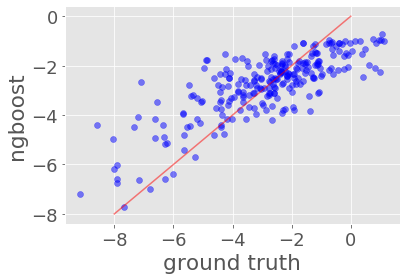

In [20]:
plt.scatter(testY2, predv, c='b', alpha=0.5)
plt.plot(np.linspace(-8,0), np.linspace(-8,0), c='r', alpha=0.5)
plt.xlabel('ground truth')
plt.ylabel('ngboost')

50it [00:00, 74.62it/s]


<Figure size 432x288 with 0 Axes>

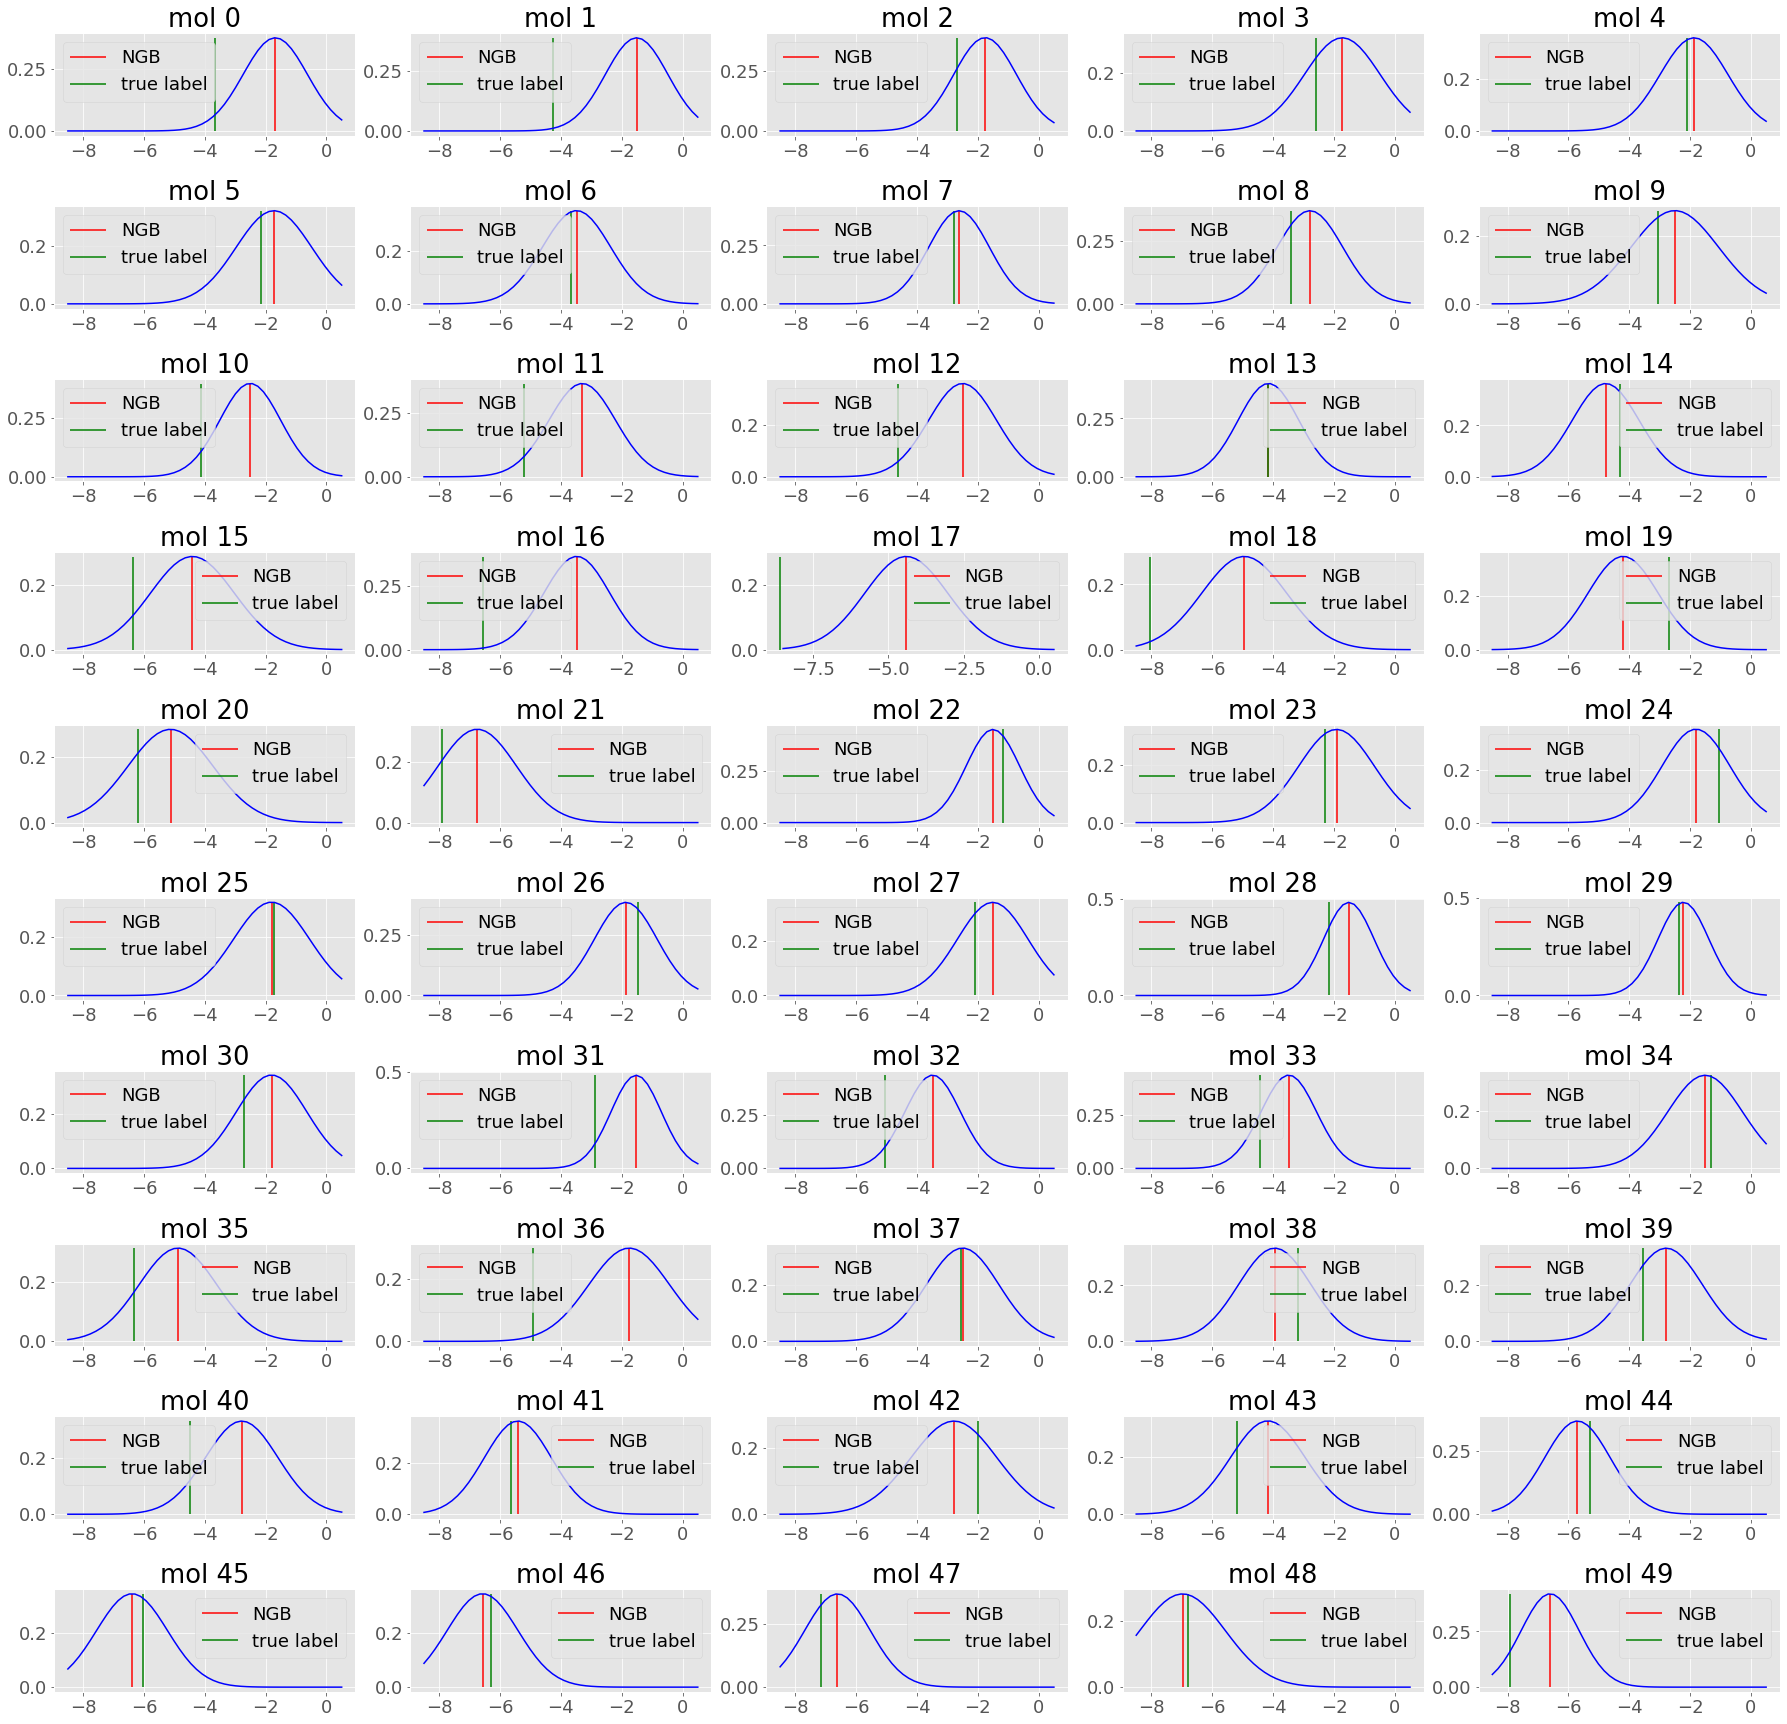

In [21]:
S = 0
E = 50
plt.clf()
plt.rcParams["font.size"] = 18
plt.figure(figsize=(25, 120))
for idx, _ in tqdm(enumerate(testX[S:E])):
    plt.subplot(E-S, 5, idx+1)
    plt.plot(yrange, distval[idx], c='b')
    plt.vlines(predv[idx], 0, max(distval[idx]), 'r', label='NGB')
    plt.vlines(testY2[idx], 0, max(distval[idx]), 'g', label='true label')
    plt.legend(loc="best")
    plt.title(f'mol {idx}')
plt.tight_layout()
plt.show()

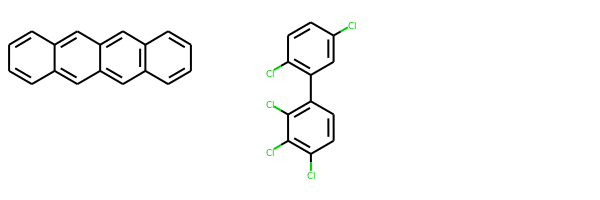

In [22]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([test_mols[17], test_mols[49]])

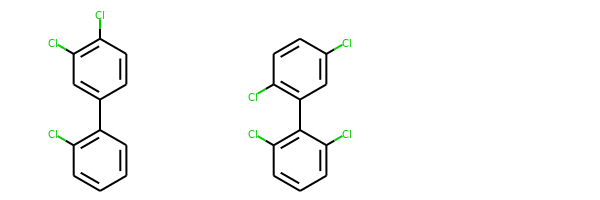

In [23]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([test_mols[46], test_mols[48]])